In [1]:
from flask import Flask, request, send_from_directory
import os
from PIL import Image
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
import torch.nn as nn
import numpy as np
import uuid
import time
import matplotlib.pyplot as plt
import mediapipe as mp

In [2]:
processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

/mnt/home/ameng/venv/lib/python3.10/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


config.json:   0%|          | 0.00/1.73k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/109M [00:00<?, ?B/s]

In [3]:
def segmentation_map(img):
    # process the image
    input = processor(images=img, return_tensors='pt')
    output = model(**input)
    logits = output.logits.cpu()

    upsampled_logits = nn.functional.interpolate(
        logits,
        size=img.size[::-1],
        mode="bilinear",
        align_corners=False,
    )

    pred_seg = upsampled_logits.argmax(dim=1)[0].cpu().numpy()
    print(pred_seg.shape)
    return pred_seg

Image Dimensions: height= 1280 pixels, width= 960 pixels


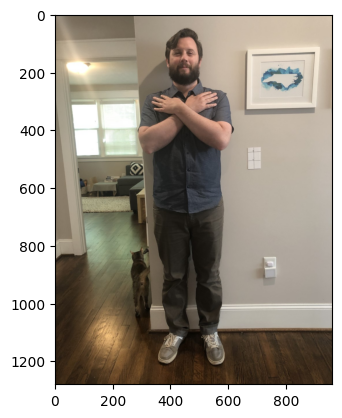

In [4]:
image_link = "lat.jpg"
img = Image.open(image_link).convert('RGB')
width, height = img.size

print("Image Dimensions: height=", height, "pixels, width=", width, "pixels")
plt.imshow(img);
plt.show()

(1280, 960)
Segmentation map of image retrieved ( 2.5269885063171387 seconds )


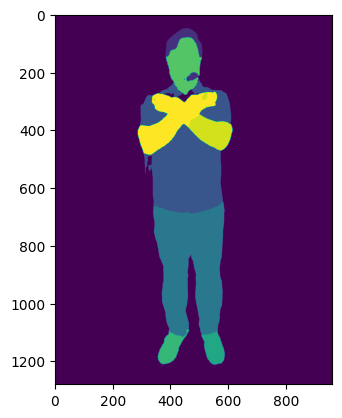

In [5]:
# retrieve segmentation mask
start = time.time()
pred_seg = segmentation_map(img)
end = time.time()
print("Segmentation map of image retrieved", "(", end - start, "seconds", ")")

plt.imshow(pred_seg)
plt.show()

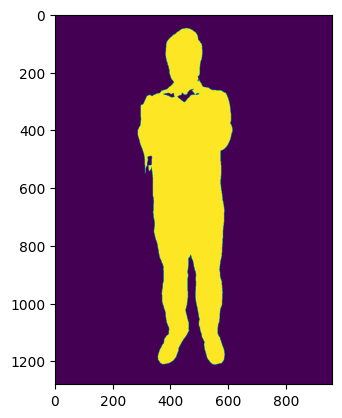

In [6]:
# get the whole body
body_mask = (pred_seg != 0)
plt.imshow(body_mask)
plt.show()

In [7]:
# calculate how many pixels from head to toe
bodyRC = np.where(body_mask)
h_min = np.min(bodyRC[0])
h_max = np.max(bodyRC[0])

print("Top Pixel: ", h_min)
print("Bottom Pixel: ", h_max)

height_in_pixels = h_max - h_min

print("Height in Pixels: ", height_in_pixels)

Top Pixel:  49
Bottom Pixel:  1212
Height in Pixels:  1163


In [8]:
# user input height in cm
user_input_height = 187
print("height of person: ", user_input_height, "cm")

height of person:  187 cm


In [9]:
cm_per_pixel = user_input_height / height_in_pixels

print("Each pixel is: ", cm_per_pixel, "cm", " in real life")

Each pixel is:  0.16079105760963028 cm  in real life


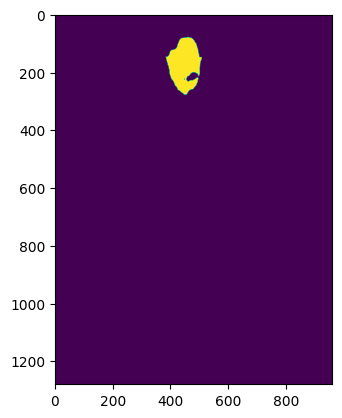

In [10]:
label_id = [11]

head_mask = np.zeros_like(pred_seg)

for label in label_id:
  label_mask = (pred_seg == label)
  head_mask = np.logical_or(label_mask, head_mask)


plt.imshow(head_mask)
plt.show()

Head width in pixels:  123 pixels


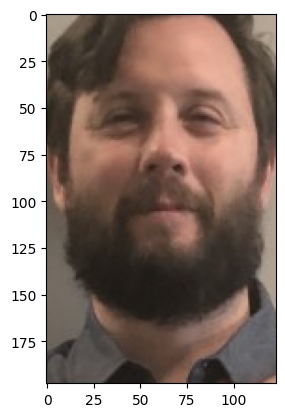

In [11]:
headRC = np.where(head_mask)
left = np.min(headRC[1])
right = np.max(headRC[1])

head_width_in_pixels = right - left

print("Head width in pixels: ", head_width_in_pixels, "pixels")

x_min = np.min(headRC[1])
x_max = np.max(headRC[1])
y_min = np.min(headRC[0])
y_max = np.max(headRC[0])

# 4. Crop the image based on the bounding box
cropped_image = img.crop((x_min, y_min, x_max, y_max))

plt.imshow(cropped_image)
plt.show()

In [17]:
head_width_in_cm = head_width_in_pixels * cm_per_pixel

print("Head width in cm: ", head_width_in_cm, "cm")

Head width in cm:  19.777300085984525 cm
